In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler



In [4]:
from sklearn.ensemble import VotingRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt


In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import numpy as np

In [8]:
df = pd.read_csv('data.csv', encoding='ISO-8859-1')
df['Order Date'] = pd.to_datetime(df['Order Date'], dayfirst=True, errors='coerce')
df.dropna(subset=['Order Date'], inplace=True)
df.set_index('Order Date', inplace=True)


In [10]:
df['Sales_Sqrt'] = df['Sales']

In [12]:
df['DayOfWeek']=df.index.dayofweek
df['IsWeekend']=(df['DayOfWeek'] >= 5).astype(int)
df['Month']=df.index.month
df['Quarter']=df.index.quarter
df['Year']=df.index.year

In [14]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

In [16]:
df['Season']=df['Month'].apply(get_season)

In [18]:
df['Season']

Order Date
2012-07-31    Summer
2013-02-05    Winter
2013-10-17      Fall
2013-01-28    Winter
2013-11-05      Fall
               ...  
2014-06-19    Summer
2014-06-20    Summer
2013-12-02    Winter
2012-02-18    Winter
2012-05-22    Spring
Name: Season, Length: 51290, dtype: object

In [20]:
for lag in range(1, 15):
    df['Lag_' + str(lag)] = df['Sales_Sqrt'].shift(lag)

In [22]:
df['Lag_3_MA'] = df['Sales_Sqrt'].shift(3).rolling(window=3).mean()
df['Lag_7_MA'] = df['Sales_Sqrt'].shift(7).rolling(window=7).mean()

In [24]:
df = pd.get_dummies(df, columns=['Category', 'Ship Mode', 'Season'], drop_first=True)

In [26]:
df['is_zero_sales'] = (df['Sales_Sqrt'] == 0).astype(int)
product_stats = df.groupby('Product ID').agg({
    'Sales_Sqrt': 'sum',
    'is_zero_sales': 'mean'
}).reset_index()

In [28]:
product_stats

,Product ID,Sales_Sqrt,is_zero_sales
0,FUR-ADV-10000002,159.120,0.0
1,FUR-ADV-10000108,350.070,0.0
2,FUR-ADV-10000183,974.832,0.0
3,FUR-ADV-10000188,124.950,0.0
4,FUR-ADV-10000190,222.360,0.0
...,...,...,...
10287,TEC-STA-10004181,3121.872,0.0
10288,TEC-STA-10004536,1810.620,0.0
10289,TEC-STA-10004542,897.792,0.0
10290,TEC-STA-10004834,204.687,0.0


In [30]:
product_stats['sales_rank']=product_stats['Sales_Sqrt'].rank(ascending=False)

In [32]:
product_stats['group'] = np.select(
    [(product_stats['sales_rank'] <= product_stats['sales_rank'].quantile(0.33)) & (product_stats['is_zero_sales'] <= product_stats['is_zero_sales'].quantile(0.33)),
     (product_stats['sales_rank'] >= product_stats['sales_rank'].quantile(0.67)) & (product_stats['is_zero_sales'] >= product_stats['is_zero_sales'].quantile(0.67))
    ],
    ['G1', 'G2'], default='G3')
df = df.merge(product_stats[['Product ID', 'group']], on='Product ID', how='left')

In [34]:
n_input=14 
n_output=7

In [36]:
df.columns

Index(['Row ID', 'Order ID', 'Ship Date', 'Customer ID', 'Customer Name',
       'Segment', 'City', 'State', 'Country', 'Postal Code', 'Market',
       'Region', 'Product ID', 'Sub-Category', 'Product Name', 'Sales',
       'Quantity', 'Discount', 'Profit', 'Shipping Cost', 'Order Priority',
       'Sales_Sqrt', 'DayOfWeek', 'IsWeekend', 'Month', 'Quarter', 'Year',
       'Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'Lag_5', 'Lag_6', 'Lag_7', 'Lag_8',
       'Lag_9', 'Lag_10', 'Lag_11', 'Lag_12', 'Lag_13', 'Lag_14', 'Lag_3_MA',
       'Lag_7_MA', 'Category_Office Supplies', 'Category_Technology',
       'Ship Mode_Same Day', 'Ship Mode_Second Class',
       'Ship Mode_Standard Class', 'Season_Spring', 'Season_Summer',
       'Season_Winter', 'is_zero_sales', 'group'],
      dtype='object')

In [38]:
for group in df['group'].unique():
    group_data=df[df['group']==group].dropna()
    features = group_data[['Sales_Sqrt', 'Season_Spring', 'Season_Summer', 'Season_Winter', 'DayOfWeek', 
                       'IsWeekend', 'Month', 'Quarter', 'Year', 'Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 
                       'Lag_5', 'Lag_6', 'Lag_7', 'Lag_8', 'Lag_9', 'Lag_10', 'Lag_11', 'Lag_12', 
                       'Lag_13', 'Lag_14', 'Lag_3_MA', 'Lag_7_MA']].values



In [40]:
def create_sequences(data, target_column_index, n_input, n_output):
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_input
        out_end_ix = end_ix + n_output
        if out_end_ix > len(data):
            break
        
        seq_x = data[i:end_ix]  
        seq_y = data[end_ix:out_end_ix, target_column_index]  
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


In [42]:
data_groups = {}  
for group in df['group'].unique():
    group_data=df[df['group']==group].dropna()  
    features=group_data[['Sales_Sqrt', 'Season_Spring', 'Season_Summer', 'Season_Winter', 'DayOfWeek', 
                       'IsWeekend', 'Month', 'Quarter', 'Year', 'Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 
                       'Lag_5', 'Lag_6', 'Lag_7', 'Lag_8', 'Lag_9', 'Lag_10', 'Lag_11', 'Lag_12', 
                       'Lag_13', 'Lag_14', 'Lag_3_MA', 'Lag_7_MA']].values
    target_column_index = 0 
    X, y=create_sequences(features, target_column_index, n_input, n_output)
    print(f"Group: {group}, X shape: {X.shape}, y shape: {y.shape}")  
    data_groups[group] = (X.reshape((X.shape[0], X.shape[1], features.shape[1])), y)


Group: G1, X shape: (3506, 14, 25), y shape: (3506, 7)
Group: G3, X shape: (2692, 14, 25), y shape: (2692, 7)
Group: G2, X shape: (3732, 14, 25), y shape: (3732, 7)


In [44]:

group_metrics = {}
data_groups = {}
n_input = 10 
n_output = 7  
features_columns = [
    'Sales_Sqrt', 'Season_Spring', 'Season_Summer', 'Season_Winter', 'DayOfWeek', 
                       'IsWeekend', 'Month', 'Quarter', 'Year', 'Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 
                       'Lag_5', 'Lag_6', 'Lag_7', 'Lag_8', 'Lag_9', 'Lag_10', 'Lag_11', 'Lag_12', 
                       'Lag_13', 'Lag_14', 'Lag_3_MA', 'Lag_7_MA'
]

In [46]:
for group in df['group'].unique():
    group_data = df[df['group'] == group].dropna()
    features = group_data[features_columns].values
    target = group_data['Sales_Sqrt'].values  
    data_groups[group] = (features, target)

In [48]:
xgb_model = XGBRegressor(n_estimators=100, max_depth=5, random_state=42)
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
lr_model = LinearRegression()

In [50]:
voting_model = VotingRegressor(estimators=[('xgb', xgb_model), ('rf', rf_model), ('lr', lr_model)])

In [52]:
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    accuracy = 100 - mape
    return mae, rmse, r2, mape, accuracy

In [54]:
def plot_actual_vs_predicted(y_true, y_pred, group):
    plt.figure(figsize=(12, 6))
    plt.plot(y_true, label="Actual", marker='o', color='b', linestyle='-')
    plt.plot(y_pred, label="Predicted", marker='x', color='r', linestyle='--')
    plt.title(f'Actual vs Predicted Sales for Group {group} (Voting Regressor)')
    plt.xlabel('Index')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid()
    plt.show()


Metrics for Group G1:
MAE: 15.029936932820997
RMSE: 215.48879447268652
R-squared: 0.9581834955363999
MAPE: 0.5963836521713591%
Accuracy: 99.40361634782865%


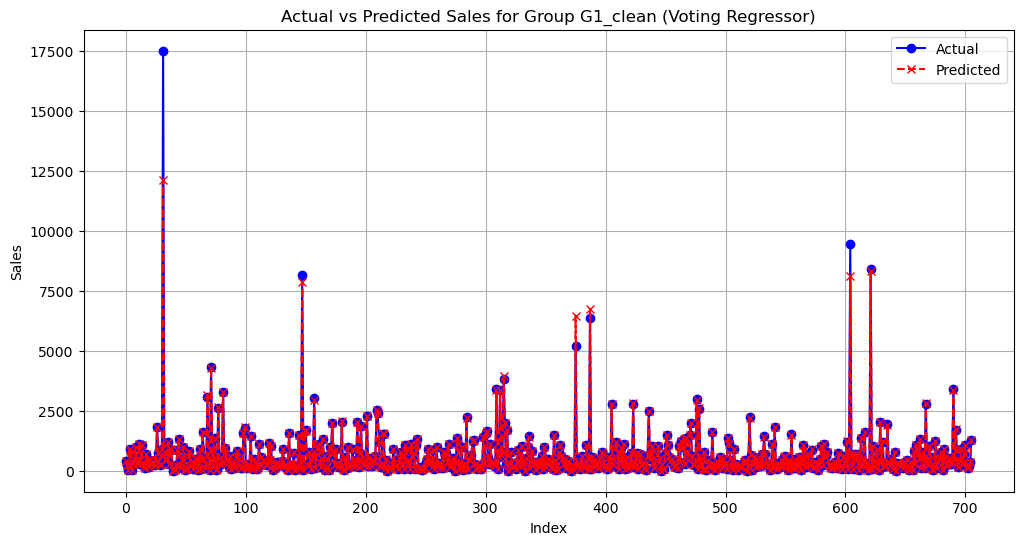


Metrics for Group G1 with Noisy Data:
MAE: 14.866327557887685
RMSE: 214.88811877024145
R-squared: 0.9584162978942281
MAPE: 0.6792703594520606%
Accuracy: 99.32072964054794%


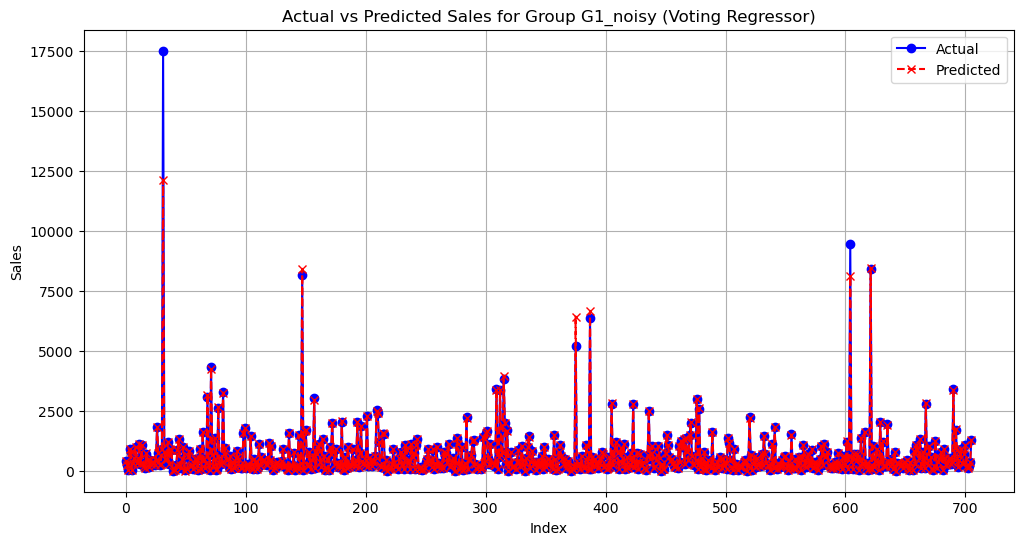

Actual Values for the Last 5 Days:  [ 179.94    99.592  196.784  359.97  1299.99 ]
Predicted Values (Clean) for the Last 5 Days:  [ 180.98806087   99.80927451  198.23864983  358.33994931 1285.69969043]
Predicted Values (Noisy) for the Last 5 Days:  [ 181.16111181   99.81556076  198.62655627  359.32259585 1289.48400179]


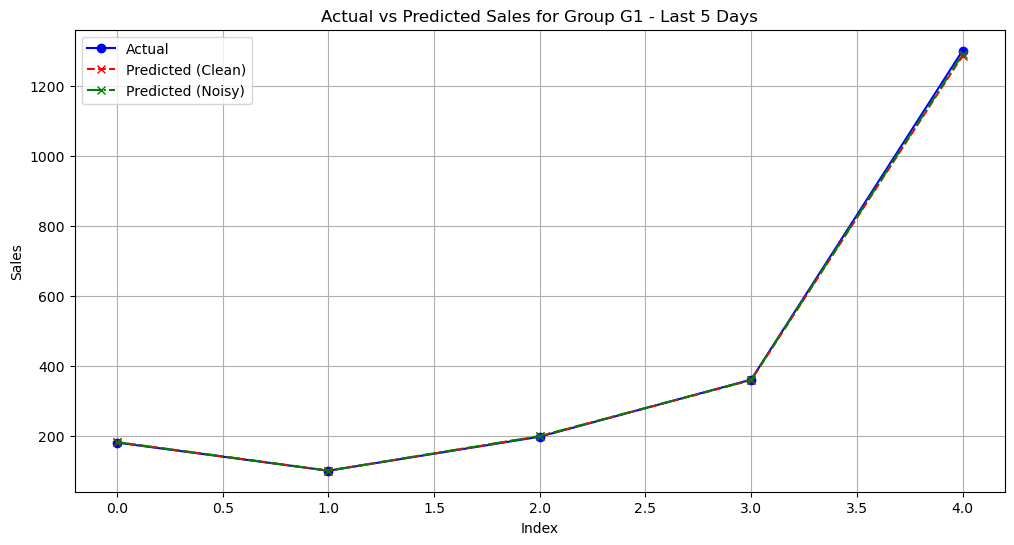


Metrics for Group G3:
MAE: 0.4202886244703194
RMSE: 2.358565238879341
R-squared: 0.9991329882218289
MAPE: 0.6827392590672339%
Accuracy: 99.31726074093277%


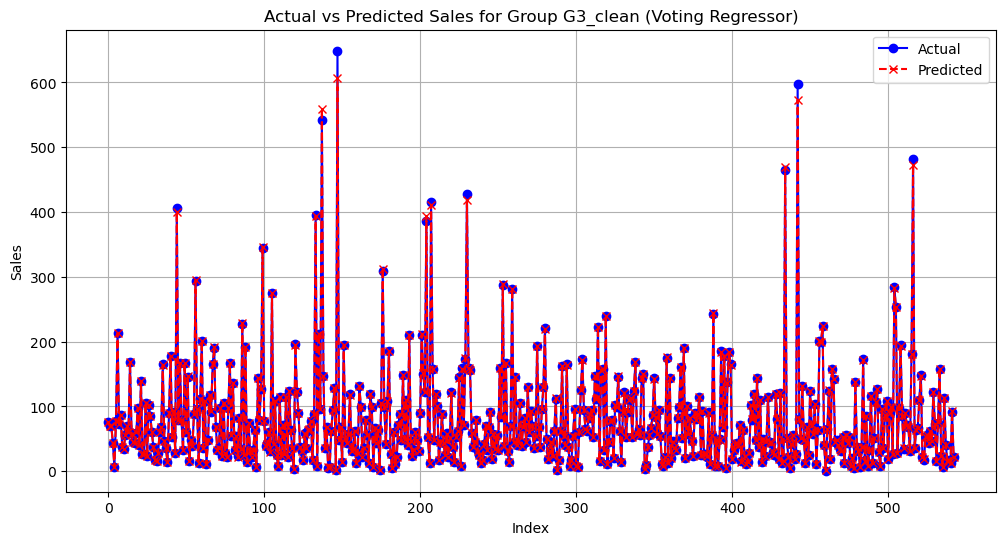


Metrics for Group G3 with Noisy Data:
MAE: 0.4555869160452612
RMSE: 2.3939235174213596
R-squared: 0.999106797864662
MAPE: 0.8606092111398169%
Accuracy: 99.13939078886018%


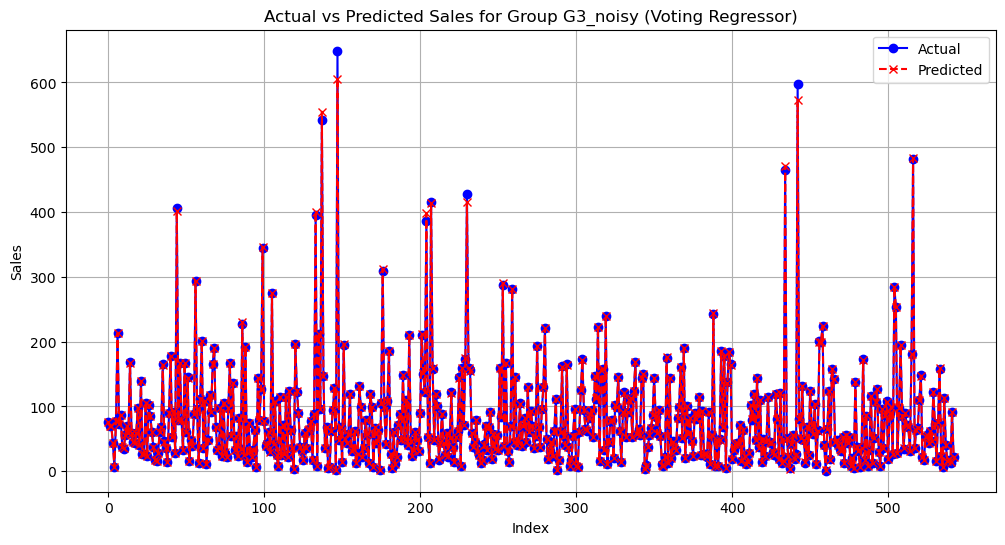

Actual Values for the Last 5 Days:  [15.88  18.176 13.428 91.92  21.48 ]
Predicted Values (Clean) for the Last 5 Days:  [16.00520423 18.05240021 13.34878227 92.29155602 21.49403905]
Predicted Values (Noisy) for the Last 5 Days:  [15.9309301  18.42959748 13.6848443  92.08759369 21.3919337 ]


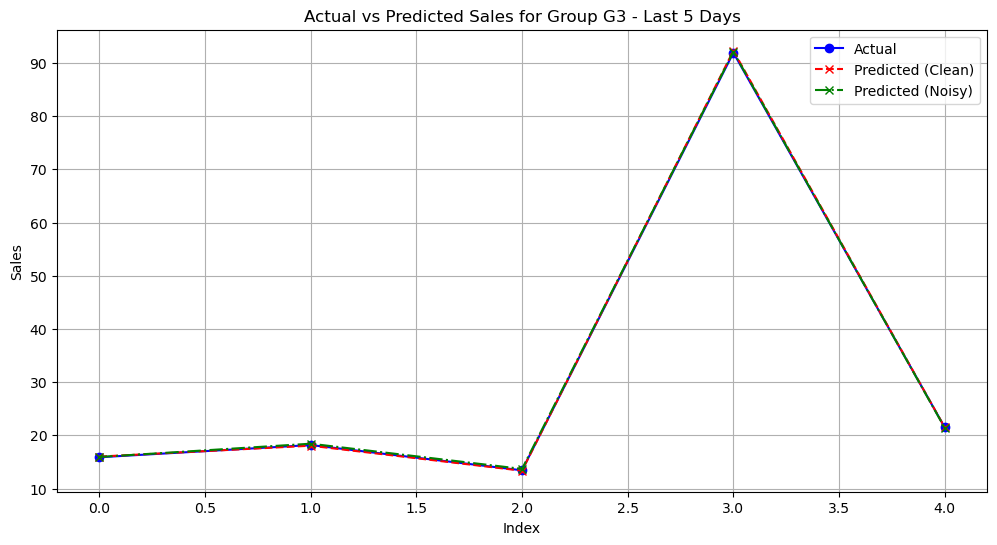


Metrics for Group G2:
MAE: 0.11781015033574166
RMSE: 1.0451387749549186
R-squared: 0.9974585252681054
MAPE: 0.36774036482984934%
Accuracy: 99.63225963517016%


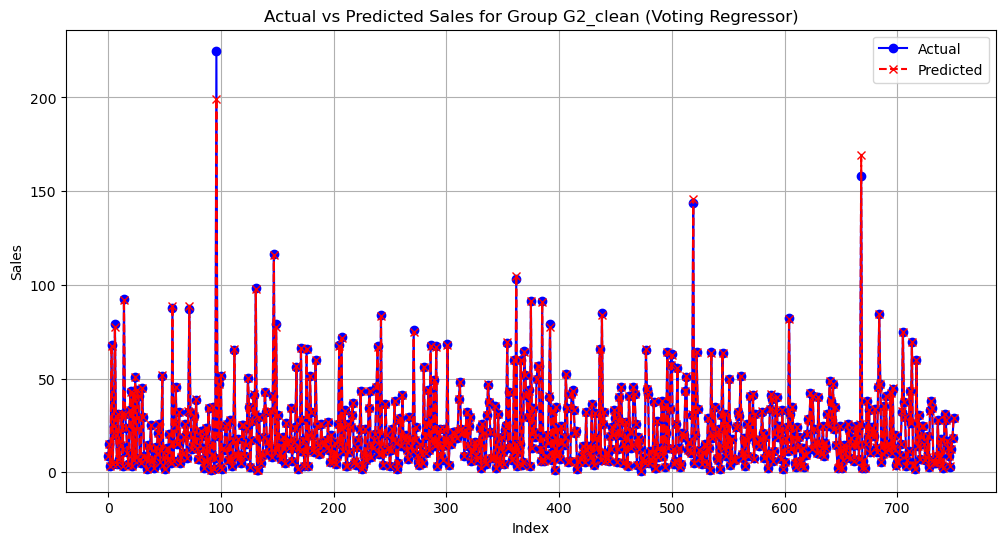


Metrics for Group G2 with Noisy Data:
MAE: 0.17471605851766756
RMSE: 1.1180213980318778
R-squared: 0.9970917073444835
MAPE: 1.0267832033572155%
Accuracy: 98.97321679664279%


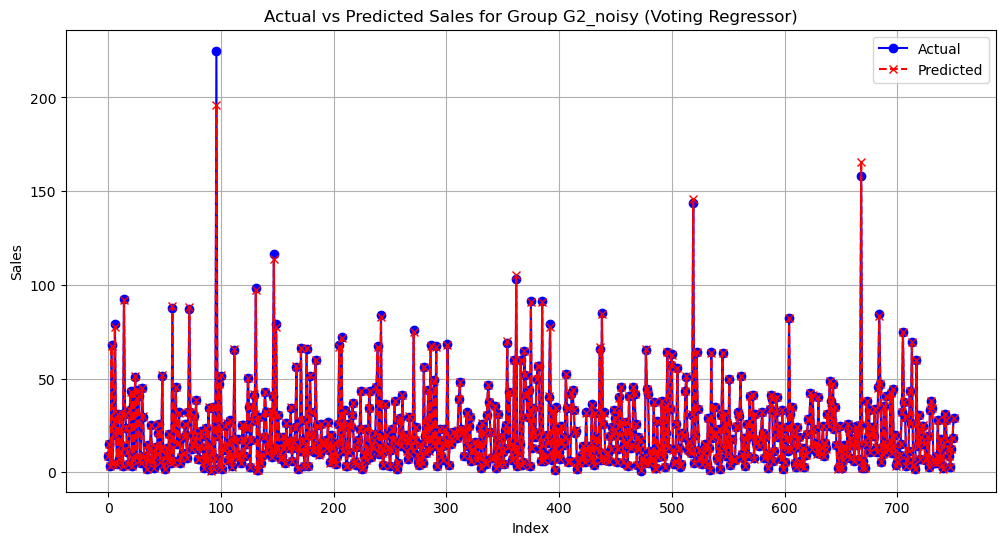

Actual Values for the Last 5 Days:  [ 8.896  3.104 12.645 18.464 28.752]
Predicted Values (Clean) for the Last 5 Days:  [ 8.89761736  3.17188134 12.63066008 18.4400232  28.85529395]
Predicted Values (Noisy) for the Last 5 Days:  [ 8.82318861  2.9399002  12.66191622 18.2895392  28.81494419]


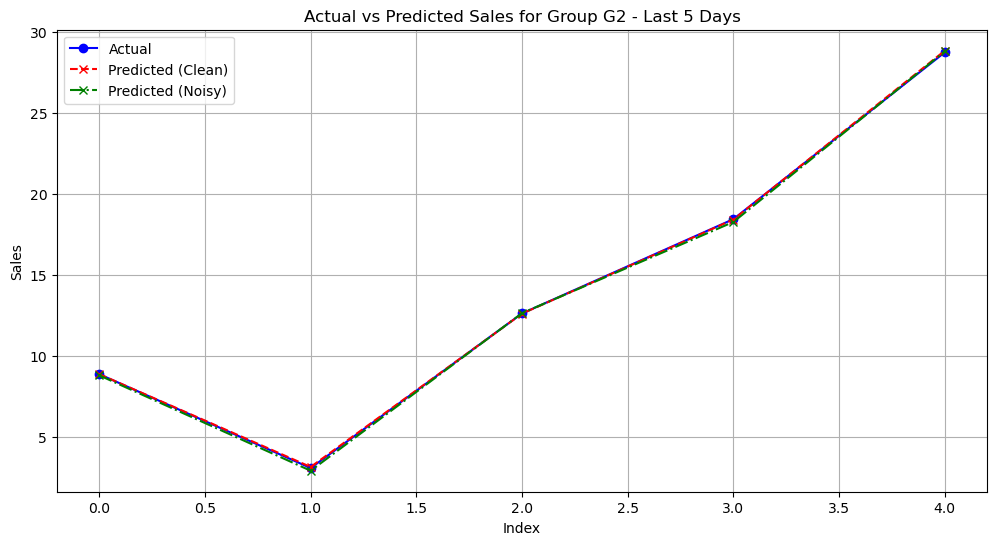

In [60]:
for group, (X, y) in data_groups.items():
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    imputer = SimpleImputer(strategy='mean')
    scaler = StandardScaler()

    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)
    
    X_train_scaled = scaler.fit_transform(X_train_imputed)
    X_test_scaled = scaler.transform(X_test_imputed)

    voting_model.fit(X_train_scaled, y_train)
    y_pred_clean = voting_model.predict(X_test_scaled)

    mae, rmse, r2, mape, accuracy = evaluate_model(y_test, y_pred_clean)

    print(f"\nMetrics for Group {group}:")
    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")
    print(f"R-squared: {r2}")
    print(f"MAPE: {mape}%")
    print(f"Accuracy: {accuracy}%")

    plot_actual_vs_predicted(y_test, y_pred_clean, f'{group}_clean')

    noise_factor = 0.1 
    X_train_noisy = X_train + noise_factor * np.random.randn(*X_train.shape)
    X_test_noisy = X_test + noise_factor * np.random.randn(*X_test.shape)

    X_train_noisy_imputed = imputer.fit_transform(X_train_noisy)
    X_test_noisy_imputed = imputer.transform(X_test_noisy)
    
    X_train_noisy_scaled = scaler.fit_transform(X_train_noisy_imputed)
    X_test_noisy_scaled = scaler.transform(X_test_noisy_imputed)

    voting_model.fit(X_train_noisy_scaled, y_train)
    y_pred_noisy = voting_model.predict(X_test_noisy_scaled)

    mae_noisy, rmse_noisy, r2_noisy, mape_noisy, accuracy_noisy = evaluate_model(y_test, y_pred_noisy)

    print(f"\nMetrics for Group {group} with Noisy Data:")
    print(f"MAE: {mae_noisy}")
    print(f"RMSE: {rmse_noisy}")
    print(f"R-squared: {r2_noisy}")
    print(f"MAPE: {mape_noisy}%")
    print(f"Accuracy: {accuracy_noisy}%")

    plot_actual_vs_predicted(y_test, y_pred_noisy, f'{group}_noisy')

    last_5_actual = y_test[-5:]
    last_5_predicted_clean = y_pred_clean[-5:]
    last_5_predicted_noisy = y_pred_noisy[-5:]

    print("Actual Values for the Last 5 Days: ", last_5_actual)
    print("Predicted Values (Clean) for the Last 5 Days: ", last_5_predicted_clean)
    print("Predicted Values (Noisy) for the Last 5 Days: ", last_5_predicted_noisy)

    plt.figure(figsize=(12, 6))
    plt.plot(last_5_actual, label="Actual", marker='o', color='b', linestyle='-')
    plt.plot(last_5_predicted_clean, label="Predicted (Clean)", marker='x', color='r', linestyle='--')
    plt.plot(last_5_predicted_noisy, label="Predicted (Noisy)", marker='x', color='g', linestyle='-.')
    plt.title(f'Actual vs Predicted Sales for Group {group} - Last 5 Days')
    plt.xlabel('Index')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid()
    plt.show()



Metrics for Group G1:
MAE: 15.029936932820997
RMSE: 215.48879447268652
R-squared: 0.9581834955363999
MAPE: 0.5963836521713591%
Accuracy: 99.40361634782865%


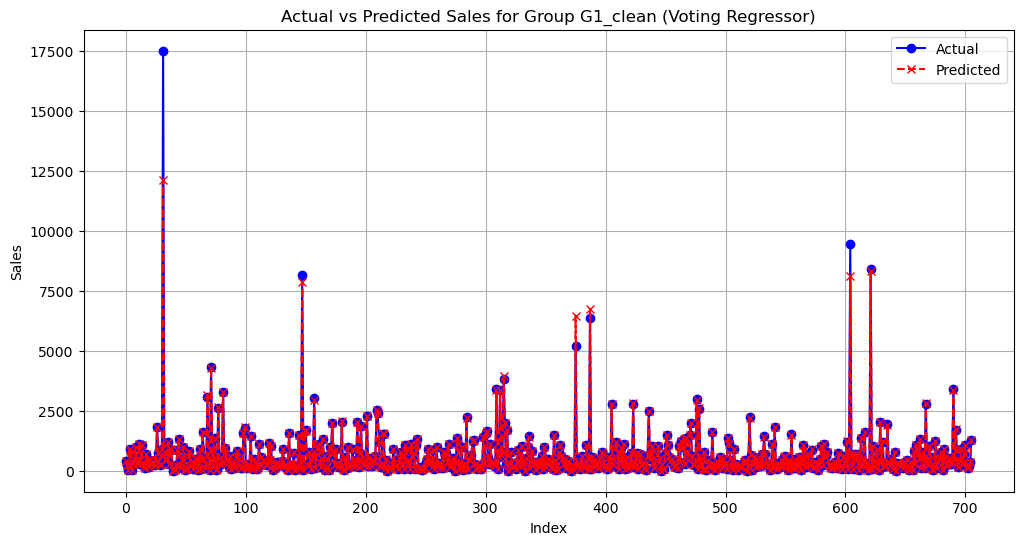


Metrics for Group G1 with Noisy Data:
MAE: 13.324015039462392
RMSE: 216.26380378170123
R-squared: 0.957882167027792
MAPE: 0.6553443521842871%
Accuracy: 99.34465564781571%


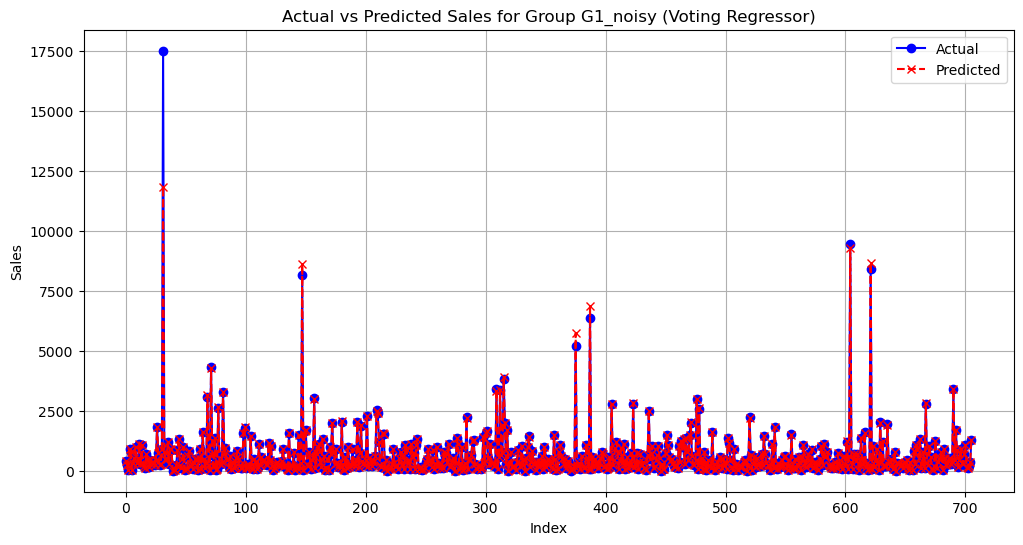


Metrics for Group G3:
MAE: 0.4202886244703194
RMSE: 2.358565238879341
R-squared: 0.9991329882218289
MAPE: 0.6827392590672339%
Accuracy: 99.31726074093277%


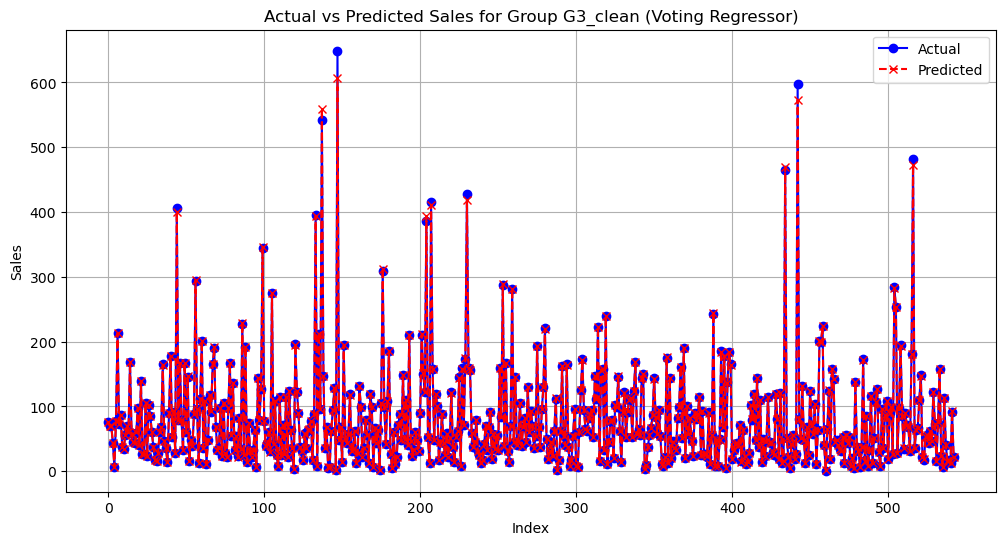


Metrics for Group G3 with Noisy Data:
MAE: 0.48524038106564
RMSE: 2.6003731060263604
R-squared: 0.998946097240093
MAPE: 0.8311219844823142%
Accuracy: 99.16887801551769%


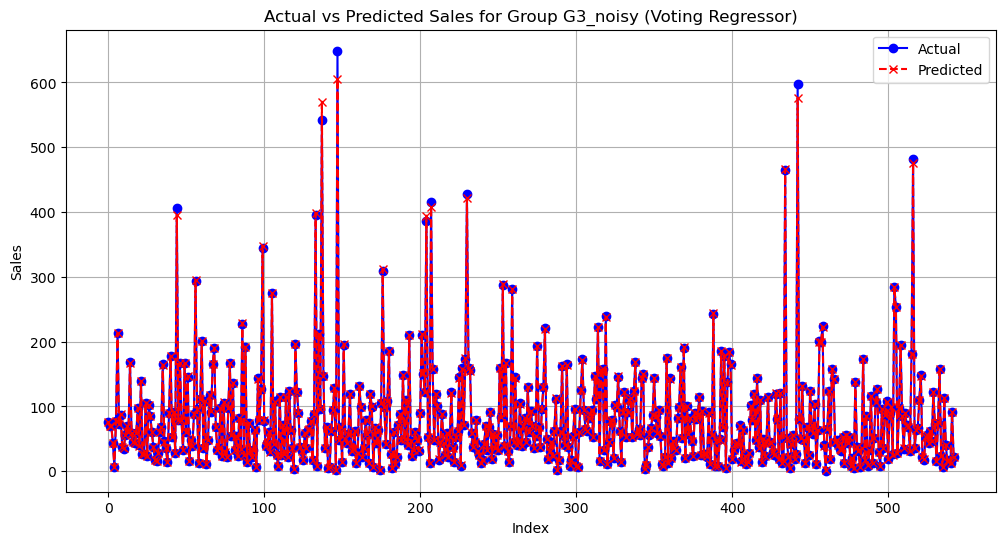


Metrics for Group G2:
MAE: 0.11781015033574166
RMSE: 1.0451387749549186
R-squared: 0.9974585252681054
MAPE: 0.36774036482984934%
Accuracy: 99.63225963517016%


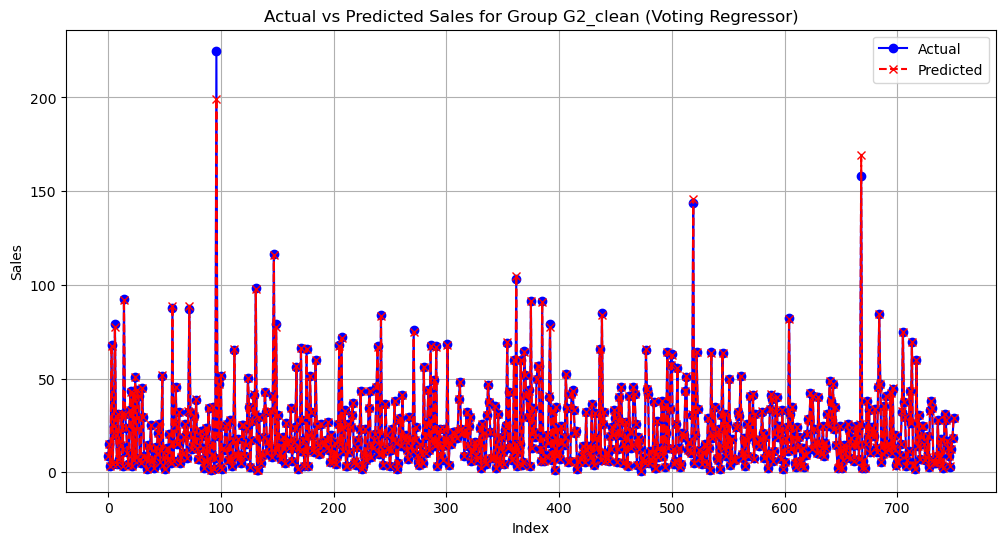


Metrics for Group G2 with Noisy Data:
MAE: 0.1777417929195277
RMSE: 0.9140405484504814
R-squared: 0.99805612291746
MAPE: 0.9929480693817547%
Accuracy: 99.00705193061825%


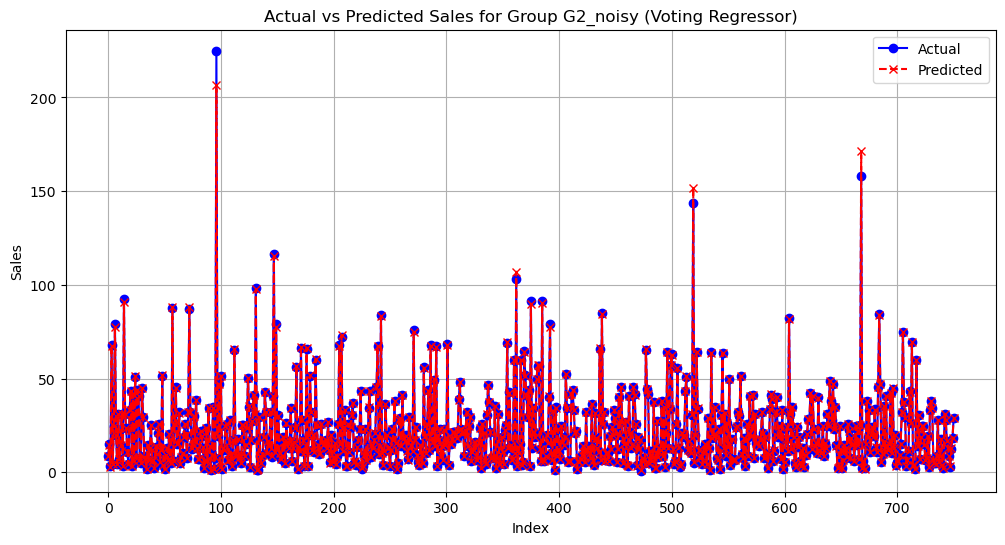

In [62]:
for group, (X, y) in data_groups.items():
   
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    
    imputer = SimpleImputer(strategy='mean')
    scaler = StandardScaler()

    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)
    
    X_train_scaled = scaler.fit_transform(X_train_imputed)
    X_test_scaled = scaler.transform(X_test_imputed)

    
    voting_model.fit(X_train_scaled, y_train)

    y_pred_clean = voting_model.predict(X_test_scaled)

   
    mae, rmse, r2, mape, accuracy = evaluate_model(y_test, y_pred_clean)

    print(f"\nMetrics for Group {group}:")
    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")
    print(f"R-squared: {r2}")
    print(f"MAPE: {mape}%")
    print(f"Accuracy: {accuracy}%")

    
    plot_actual_vs_predicted(y_test, y_pred_clean, f'{group}_clean')

    
    noise_factor = 0.1 
    X_train_noisy = X_train + noise_factor * np.random.randn(*X_train.shape)
    X_test_noisy = X_test + noise_factor * np.random.randn(*X_test.shape)

    
    X_train_noisy_imputed = imputer.fit_transform(X_train_noisy)
    X_test_noisy_imputed = imputer.transform(X_test_noisy)
    
    X_train_noisy_scaled = scaler.fit_transform(X_train_noisy_imputed)
    X_test_noisy_scaled = scaler.transform(X_test_noisy_imputed)

    
    voting_model.fit(X_train_noisy_scaled, y_train)

    
    y_pred_noisy = voting_model.predict(X_test_noisy_scaled)


    mae_noisy, rmse_noisy, r2_noisy, mape_noisy, accuracy_noisy = evaluate_model(y_test, y_pred_noisy)

    print(f"\nMetrics for Group {group} with Noisy Data:")
    print(f"MAE: {mae_noisy}")
    print(f"RMSE: {rmse_noisy}")
    print(f"R-squared: {r2_noisy}")
    print(f"MAPE: {mape_noisy}%")
    print(f"Accuracy: {accuracy_noisy}%")

    
    plot_actual_vs_predicted(y_test, y_pred_noisy, f'{group}_noisy')


In [64]:
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model1 = LinearRegression()
model2 = DecisionTreeRegressor()
model3 = RandomForestRegressor()


voting_model = VotingRegressor(estimators=[
    ('lr', model1),
    ('dt', model2),
    ('rf', model3)
])


param_grid = {
    'weights': [[1, 1, 1], [2, 1, 1], [1, 2, 1]],  
    'rf__n_estimators': [50, 100],                
    'rf__max_depth': [10, 20],                    
    'dt__max_depth': [5, 10]                      
}


grid_search = GridSearchCV(estimator=voting_model, param_grid=param_grid, cv=3, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)


print("Best Parameters:", grid_search.best_params_)
print("Best Score:", -grid_search.best_score_)


best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"Test MAE: {mae}")
print(f"Test RMSE: {rmse}")
print(f"Test R-squared: {r2}")


Best Parameters: {'dt__max_depth': 10, 'rf__max_depth': 20, 'rf__n_estimators': 100, 'weights': [2, 1, 1]}
Best Score: 0.062049308635243154
Test MAE: 0.06304917179565027
Test RMSE: 0.6878808451060718
Test R-squared: 0.9988990583359169


C:\Anaconda\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



Metrics for Group G1 (Clean Data):
MAE: 5.0332
RMSE: 88.4818
R-squared: 0.9929
MAPE: 0.21%
Accuracy: 99.79%


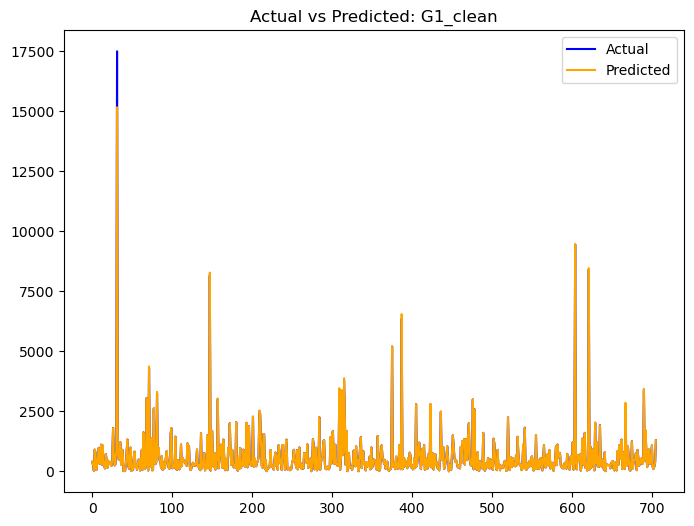


Metrics for Group G1 (Noisy Data):
MAE: 6.4218
RMSE: 96.9910
R-squared: 0.9915
MAPE: 0.23%
Accuracy: 99.77%


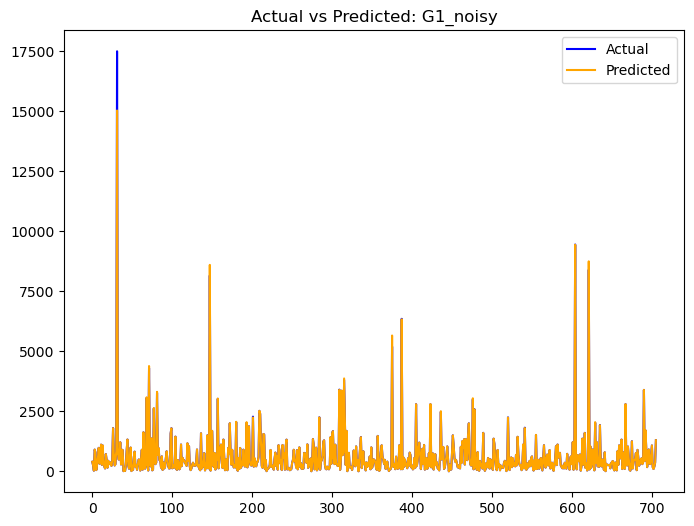

Cross-validated MAE for Group G1: 6.8014

Metrics for Group G3 (Clean Data):
MAE: 0.1781
RMSE: 1.2834
R-squared: 0.9997
MAPE: 0.34%
Accuracy: 99.66%


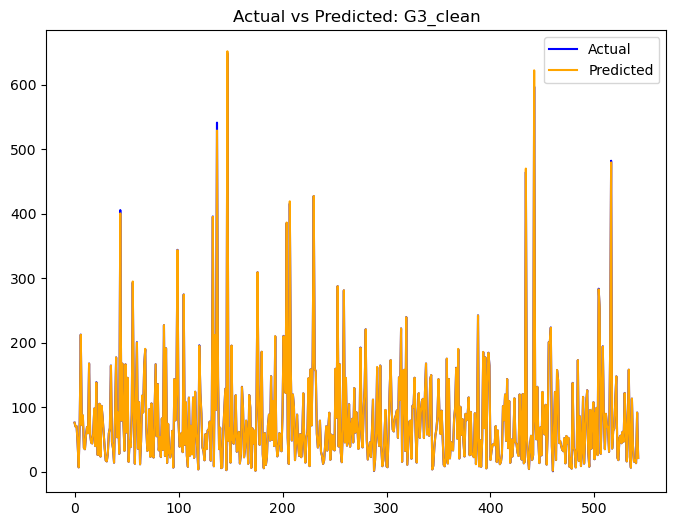


Metrics for Group G3 (Noisy Data):
MAE: 0.2077
RMSE: 0.8732
R-squared: 0.9999
MAPE: 0.43%
Accuracy: 99.57%


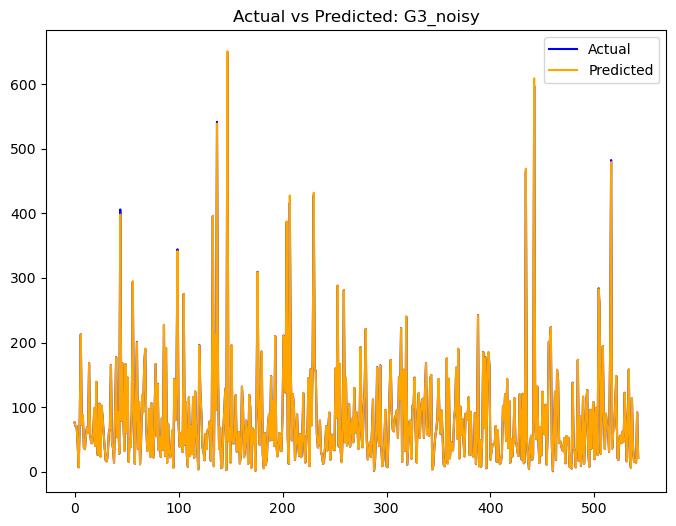

Cross-validated MAE for Group G3: 0.2188

Metrics for Group G2 (Clean Data):
MAE: 0.0582
RMSE: 0.6044
R-squared: 0.9992
MAPE: 0.12%
Accuracy: 99.88%


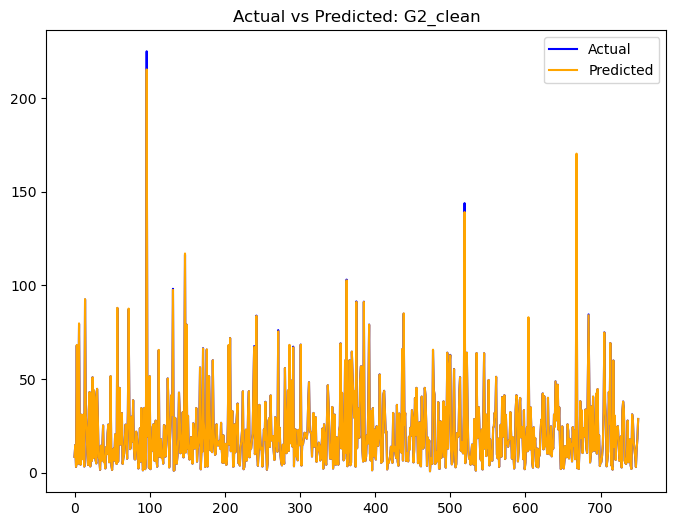


Metrics for Group G2 (Noisy Data):
MAE: 0.1276
RMSE: 0.6393
R-squared: 0.9990
MAPE: 0.88%
Accuracy: 99.12%


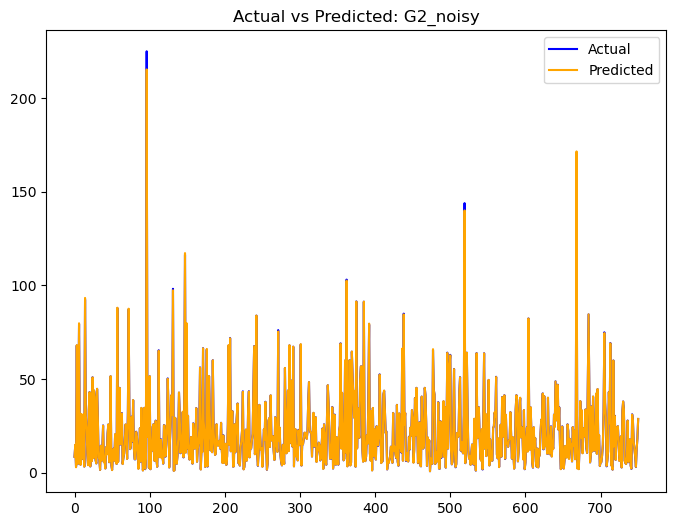

Cross-validated MAE for Group G2: 0.0567


In [70]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


def evaluate_model(y_true, y_pred):
    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    r2 = 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    accuracy = 100 - mape
    return mae, rmse, r2, mape, accuracy


def plot_actual_vs_predicted(y_true, y_pred, title):
    plt.figure(figsize=(8, 6))
    plt.plot(y_true, label="Actual", color="blue")
    plt.plot(y_pred, label="Predicted", color="orange")
    plt.title(f"Actual vs Predicted: {title}")
    plt.legend()
    plt.show()


voting_model = VotingRegressor(estimators=[
    ('lr', LinearRegression()), 
    ('dt', DecisionTreeRegressor(max_depth=10)), 
    ('rf', RandomForestRegressor(n_estimators=50, max_depth=20))
], weights=[2, 1, 1])


for group, (X, y) in data_groups.items():
   
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


    imputer = SimpleImputer(strategy='mean')
    scaler = StandardScaler()

    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)
    
    X_train_scaled = scaler.fit_transform(X_train_imputed)
    X_test_scaled = scaler.transform(X_test_imputed)

    
    voting_model.fit(X_train_scaled, y_train)

    
    y_pred_clean = voting_model.predict(X_test_scaled)

    
    mae, rmse, r2, mape, accuracy = evaluate_model(y_test, y_pred_clean)
    print(f"\nMetrics for Group {group} (Clean Data):")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R-squared: {r2:.4f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"Accuracy: {accuracy:.2f}%")

    
    plot_actual_vs_predicted(y_test, y_pred_clean, f'{group}_clean')

    
    noise_factor = 0.1
    X_train_noisy = X_train + noise_factor * np.random.randn(*X_train.shape)
    X_test_noisy = X_test + noise_factor * np.random.randn(*X_test.shape)

    
    X_train_noisy_imputed = imputer.fit_transform(X_train_noisy)
    X_test_noisy_imputed = imputer.transform(X_test_noisy)
    
    X_train_noisy_scaled = scaler.fit_transform(X_train_noisy_imputed)
    X_test_noisy_scaled = scaler.transform(X_test_noisy_imputed)

    
    voting_model.fit(X_train_noisy_scaled, y_train)

    
    y_pred_noisy = voting_model.predict(X_test_noisy_scaled)

    
    mae_noisy, rmse_noisy, r2_noisy, mape_noisy, accuracy_noisy = evaluate_model(y_test, y_pred_noisy)
    print(f"\nMetrics for Group {group} (Noisy Data):")
    print(f"MAE: {mae_noisy:.4f}")
    print(f"RMSE: {rmse_noisy:.4f}")
    print(f"R-squared: {r2_noisy:.4f}")
    print(f"MAPE: {mape_noisy:.2f}%")
    print(f"Accuracy: {accuracy_noisy:.2f}%")

    
    plot_actual_vs_predicted(y_test, y_pred_noisy, f'{group}_noisy')

    
    cv_scores = cross_val_score(voting_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_absolute_error')
    print(f"Cross-validated MAE for Group {group}: {-cv_scores.mean():.4f}")


In [58]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
